In [1]:
# 首先导入包
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
import math
from torch.nn import functional as F
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.nn import GCNConv

In [2]:
data = pd.read_csv("TripData_cleaned.csv")
data = data.drop('Unnamed: 0', axis=1)

data.head()

,lpep_pickup_datetime,Lpep_dropoff_datetime,Passenger_count,Trip_distance,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Total_amount,Trip_duration,Pickup_time,Speed,Pickup_cluster,Dropoff_cluster,year,month,day,time_span
0,2015-04-01 00:00:00,2015/4/1 0:08,1,3.08,-73.958817,40.716824,-73.982971,40.696007,14.76,8.0,1.427818e+09,23.100000,7,25,2015,4,1,0
1,2015-04-01 00:00:00,2015/4/1 0:07,1,1.21,-73.937531,40.804501,-73.946800,40.815998,8.30,7.0,1.427818e+09,10.371429,11,11,2015,4,1,0
2,2015-04-01 00:00:00,2015/4/1 0:02,1,0.64,-73.955818,40.681152,-73.955406,40.687145,6.00,2.0,1.427818e+09,19.200000,0,18,2015,4,1,0
3,2015-04-01 00:00:00,2015/4/1 0:05,1,1.34,-73.830551,40.759460,-73.825363,40.741589,7.80,5.0,1.427818e+09,16.080000,20,20,2015,4,1,0
4,2015-04-01 00:00:00,2015/4/1 0:05,1,0.98,-73.912086,40.775356,-73.915474,40.764091,7.30,5.0,1.427818e+09,11.760000,17,19,2015,4,1,0


In [3]:
# 根据指定的列进行分组，并对Passenger_count进行求和
grouped_data = data.groupby(['year', 'month', 'day', 'time_span', 'Pickup_cluster','Dropoff_cluster']).agg(
    {'Passenger_count': 'sum'}).reset_index()
# 将列名 'time_span' 修改为 'hour'
grouped_data = grouped_data.rename(columns={'time_span': 'hour'})

# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 因此我们使用 .values.reshape(-1, 1) 转换 Pickup_cluster 列
grouped_data['Passenger_count'] = scaler.fit_transform(grouped_data[['Passenger_count']])

grouped_data.head()

,year,month,day,hour,Pickup_cluster,Dropoff_cluster,Passenger_count
0,2015,4,1,0,0,0,0.028261
1,2015,4,1,0,0,7,0.010870
2,2015,4,1,0,0,10,0.015217
3,2015,4,1,0,0,11,0.002174
4,2015,4,1,0,0,12,0.019565


In [4]:
# 获取所有独特的cluster
all_clusters = np.union1d(grouped_data['Pickup_cluster'].unique(), grouped_data['Dropoff_cluster'].unique())

# 初始化存储所有图的字典
graphs = []
features = []

# 遍历每个独特的年月日小时组合
for (year, month, day, hour), group in grouped_data.groupby(['year', 'month', 'day', 'hour']):
    # 初始化图矩阵
    graph_matrix = np.zeros((len(all_clusters), len(all_clusters)))

    # 填充图矩阵
    for _, row in group.iterrows():
        pickup_idx = np.where(all_clusters == row['Pickup_cluster'])[0][0]
        dropoff_idx = np.where(all_clusters == row['Dropoff_cluster'])[0][0]
        graph_matrix[pickup_idx, dropoff_idx] = row['Passenger_count']

    features_list = []
    for i in range(len(graph_matrix)):
        temp_features = []
        temp_features.append(year)
        temp_features.append(month)
        temp_features.append(day)
        temp_features.append(hour)
        temp_features.append(graph_matrix[i].sum())
        features_list.append(temp_features)
    features.append(features_list)
    # 将图矩阵添加到字典
    graphs.append(graph_matrix)

In [5]:
graphs = np.array(graphs)
features = np.array(features)

In [6]:
graphs.shape

(449, 30, 30)

In [7]:
graphs

array([[[0.02826087, 0.        , 0.        , ..., 0.        ,
         0.        , 0.00217391],
        [0.        , 0.05434783, 0.00217391, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.17826087, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.01304348,
         0.        , 0.        ],
        [0.        , 0.00217391, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.00217391, 0.        , 0.        , ..., 0.00217391,
         0.        , 0.00434783]],

       [[0.02608696, 0.        , 0.        , ..., 0.00652174,
         0.        , 0.00217391],
        [0.        , 0.02608696, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.00217391, 0.12826087, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00434783,
         0.        , 0.        ],
        [0. 

In [8]:
class TripData(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [9]:
class GNN_LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GNN_LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device) # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device)  # 初始化记忆状态c0
        #print(f"x.shape:{x.shape},h0.shape:{h0.shape},c0.shape:{c0.shape}")
        out, _ = self.lstm(x, (h0, c0))  # LSTM前向传播
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出作为预测结果
        return out

In [10]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3,4] # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

In [11]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss() # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    optimizer=torch.optim.Adam(model.parameters(),lr=config['learning_rate'],betas=(0.5,0.999))

    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
#             print("y:",y)
#             print("pred:",pred)
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Test loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/Test', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 20010106,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'test_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 16, 
    'learning_rate': 5e-5,              
    'early_stop': 50,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/GNNLSTM.ckpt'  # Your model will be saved here.
}

In [13]:
print(f"len(graphs):{len(graphs)}")

len(graphs):449


In [14]:
def split_data(data,time_step=24):
    dataX=[]
    datay=[]
    dataNew = []
    for i in range(len(data)-time_step):
        dataX.append(data[i:i+time_step])
        datay.append(data[i+time_step])
        dataNew.append(data[i:i+time_step+1])
    dataX=np.array(dataX).reshape(len(dataX),time_step,-1)
    datay=np.array(datay)
    dataNew=np.array(dataNew).reshape(len(dataNew),time_step+1,-1)
    return dataX,datay,dataNew

In [15]:
dataX,datay, dataNew=split_data(graphs)
print(f"dataX.shape:{dataX.shape},datay.shape:{datay.shape},dataNew.shape:{dataNew.shape}")

dataX.shape:(425, 24, 900),datay.shape:(425, 30, 30),dataNew.shape:(425, 25, 900)


In [16]:
# 计算验证集的大小（后10%的数据）
valid_size = int(len(dataNew) * 0.1)

# 从数据集的末尾取后10%作为验证集
valid_data = dataNew[-valid_size:]

In [17]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_test_split(data_set, test_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(test_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [18]:
train_data, test_data = train_test_split(dataNew, config['test_ratio'], config['seed'])

# Select features
x_train, x_test, y_train, y_test = train_data[:,:-1], test_data[:,:-1], train_data[:,-1], test_data[:,-1],

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

len(train_data)

number of features: 24


340

In [19]:
train_dataset, valid_dataset = TripData(x_train, y=y_train), TripData(x_test, y=y_test),

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

In [20]:
# 定义输入、隐藏状态和输出维度
input_size = dataNew.shape[2]  # 输入特征维度
hidden_size = 256  # LSTM隐藏状态维度
num_layers = 8  # LSTM层数
output_size = dataNew.shape[2]  # 输出维度（预测目标维度）

In [21]:
model = GNN_LSTM_model(input_size, hidden_size, num_layers, output_size).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 27.76it/s, loss=0.00126]


Epoch [1/500]: Train loss: 0.0018, Test loss: 0.0015
Saving model with loss 0.002...


Epoch [2/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.73it/s, loss=0.000454]


Epoch [2/500]: Train loss: 0.0011, Test loss: 0.0007
Saving model with loss 0.001...


Epoch [3/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.18it/s, loss=0.00026]


Epoch [3/500]: Train loss: 0.0004, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [4/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.76it/s, loss=0.000251]


Epoch [4/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [5/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.96it/s, loss=0.000202]


Epoch [5/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [6/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.97it/s, loss=0.000342]


Epoch [6/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [7/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.83it/s, loss=0.000174]


Epoch [7/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [8/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.10it/s, loss=0.000524]


Epoch [8/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [9/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.61it/s, loss=0.000287]


Epoch [9/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [10/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.75it/s, loss=0.000265]


Epoch [10/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [11/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 44.10it/s, loss=0.00022]


Epoch [11/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [12/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.38it/s, loss=0.000297]


Epoch [12/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [13/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.57it/s, loss=0.000131]


Epoch [13/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [14/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 44.26it/s, loss=0.000188]


Epoch [14/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [15/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.51it/s, loss=0.000603]


Epoch [15/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [16/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.37it/s, loss=0.000257]


Epoch [16/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [17/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.34it/s, loss=0.000212]


Epoch [17/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [18/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.26it/s, loss=0.000148]


Epoch [18/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [19/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.63it/s, loss=0.000221]


Epoch [19/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [20/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.71it/s, loss=0.000266]


Epoch [20/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [21/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.82it/s, loss=0.000219]


Epoch [21/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [22/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.54it/s, loss=0.000315]


Epoch [22/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [23/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.39it/s, loss=0.000444]


Epoch [23/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [24/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.26it/s, loss=0.000296]


Epoch [24/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [25/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.77it/s, loss=0.000217]


Epoch [25/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [26/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.27it/s, loss=0.000485]


Epoch [26/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [27/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.30it/s, loss=0.000234]


Epoch [27/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [28/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.79it/s, loss=0.000306]


Epoch [28/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [29/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.68it/s, loss=0.000193]


Epoch [29/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [30/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.54it/s, loss=0.00012]


Epoch [30/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [31/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.72it/s, loss=0.000389]


Epoch [31/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [32/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.54it/s, loss=0.00021]


Epoch [32/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [33/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.58it/s, loss=0.000416]


Epoch [33/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [34/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.93it/s, loss=0.000256]


Epoch [34/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [35/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.60it/s, loss=0.000327]


Epoch [35/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [36/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.47it/s, loss=0.000214]


Epoch [36/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [37/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.16it/s, loss=0.000123]


Epoch [37/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [38/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 41.60it/s, loss=0.000283]


Epoch [38/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [39/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.42it/s, loss=0.000346]


Epoch [39/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [40/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.04it/s, loss=0.000177]


Epoch [40/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [41/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.55it/s, loss=0.000237]


Epoch [41/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [42/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.00it/s, loss=0.000181]


Epoch [42/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [43/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.70it/s, loss=0.000317]


Epoch [43/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [44/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.23it/s, loss=0.000163]


Epoch [44/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [45/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.28it/s, loss=0.000162]


Epoch [45/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [46/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.10it/s, loss=0.000209]


Epoch [46/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [47/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.94it/s, loss=9.6e-5]


Epoch [47/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [48/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.11it/s, loss=0.000292]


Epoch [48/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [49/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.60it/s, loss=0.000121]


Epoch [49/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [50/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.61it/s, loss=0.00017]


Epoch [50/500]: Train loss: 0.0001, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [51/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 50.08it/s, loss=5.49e-5]


Epoch [51/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [52/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.03it/s, loss=0.000186]


Epoch [52/500]: Train loss: 0.0001, Test loss: 0.0002


Epoch [53/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.82it/s, loss=7.51e-5]


Epoch [53/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [54/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.04it/s, loss=0.000131]


Epoch [54/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [55/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.14it/s, loss=0.000115]


Epoch [55/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [56/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.99it/s, loss=0.000115]


Epoch [56/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [57/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 44.84it/s, loss=0.000155]


Epoch [57/500]: Train loss: 0.0001, Test loss: 0.0002


Epoch [58/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.32it/s, loss=7.85e-5]


Epoch [58/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [59/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.44it/s, loss=0.000128]


Epoch [59/500]: Train loss: 0.0001, Test loss: 0.0002


Epoch [60/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.08it/s, loss=0.00025]


Epoch [60/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [61/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.67it/s, loss=7.14e-5]


Epoch [61/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [62/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.36it/s, loss=9.92e-5]


Epoch [62/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [63/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.10it/s, loss=0.000166]


Epoch [63/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [64/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.39it/s, loss=7.27e-5]


Epoch [64/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [65/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.96it/s, loss=0.000132]


Epoch [65/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [66/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.70it/s, loss=3.95e-5]


Epoch [66/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [67/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.44it/s, loss=0.000115]


Epoch [67/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [68/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.91it/s, loss=8.11e-5]


Epoch [68/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [69/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.13it/s, loss=9.28e-5]


Epoch [69/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [70/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.52it/s, loss=7.04e-5]


Epoch [70/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [71/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.32it/s, loss=0.000112]


Epoch [71/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [72/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.95it/s, loss=9.68e-5]


Epoch [72/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [73/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.25it/s, loss=7.8e-5]


Epoch [73/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [74/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.50it/s, loss=6.13e-5]


Epoch [74/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [75/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.85it/s, loss=0.0001]


Epoch [75/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [76/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.04it/s, loss=0.000152]


Epoch [76/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [77/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.50it/s, loss=0.000103]


Epoch [77/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [78/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.94it/s, loss=6.22e-5]


Epoch [78/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [79/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.58it/s, loss=0.000142]


Epoch [79/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [80/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.01it/s, loss=7.51e-5]


Epoch [80/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [81/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.27it/s, loss=0.00013]


Epoch [81/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [82/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.89it/s, loss=0.00014]


Epoch [82/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [83/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.38it/s, loss=8.28e-5]


Epoch [83/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [84/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.27it/s, loss=0.000124]


Epoch [84/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [85/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.45it/s, loss=0.000127]


Epoch [85/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [86/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.41it/s, loss=7.06e-5]


Epoch [86/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [87/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.15it/s, loss=8.3e-5]


Epoch [87/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [88/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.29it/s, loss=0.00011]


Epoch [88/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [89/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.09it/s, loss=0.000117]


Epoch [89/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [90/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.79it/s, loss=0.000108]


Epoch [90/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [91/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.15it/s, loss=7.32e-5]


Epoch [91/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [92/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.58it/s, loss=0.000133]


Epoch [92/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [93/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 50.00it/s, loss=7.51e-5]


Epoch [93/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [94/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.65it/s, loss=9.17e-5]


Epoch [94/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [95/500]: 100%|███████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.51it/s, loss=7e-5]


Epoch [95/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [96/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.43it/s, loss=9.84e-5]


Epoch [96/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [97/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.59it/s, loss=0.000128]


Epoch [97/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [98/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.91it/s, loss=5.95e-5]


Epoch [98/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [99/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.36it/s, loss=0.000106]


Epoch [99/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [100/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.47it/s, loss=7.32e-5]


Epoch [100/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [101/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.10it/s, loss=6.21e-5]


Epoch [101/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [102/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.10it/s, loss=7.14e-5]


Epoch [102/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [103/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.02it/s, loss=9.49e-5]


Epoch [103/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [104/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.01it/s, loss=5.21e-5]


Epoch [104/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [105/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.39it/s, loss=7.59e-5]


Epoch [105/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [106/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.31it/s, loss=5.69e-5]


Epoch [106/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [107/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.26it/s, loss=0.000107]


Epoch [107/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [108/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.14it/s, loss=7.98e-5]


Epoch [108/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [109/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.99it/s, loss=7.15e-5]


Epoch [109/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [110/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.41it/s, loss=0.000147]


Epoch [110/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [111/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.70it/s, loss=7.41e-5]


Epoch [111/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [112/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.13it/s, loss=7.13e-5]


Epoch [112/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [113/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.90it/s, loss=7.42e-5]


Epoch [113/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [114/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.04it/s, loss=0.000125]


Epoch [114/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [115/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.05it/s, loss=5.42e-5]


Epoch [115/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [116/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.93it/s, loss=7.39e-5]


Epoch [116/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [117/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.63it/s, loss=6.54e-5]


Epoch [117/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [118/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.71it/s, loss=7.31e-5]


Epoch [118/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [119/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.35it/s, loss=6.27e-5]


Epoch [119/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [120/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.18it/s, loss=8.09e-5]


Epoch [120/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [121/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.81it/s, loss=4.95e-5]


Epoch [121/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [122/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.90it/s, loss=4.52e-5]


Epoch [122/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [123/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.84it/s, loss=6.33e-5]


Epoch [123/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [124/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.83it/s, loss=8.04e-5]


Epoch [124/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [125/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.71it/s, loss=7.53e-5]


Epoch [125/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [126/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.20it/s, loss=6.8e-5]


Epoch [126/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [127/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.07it/s, loss=6.99e-5]


Epoch [127/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [128/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.39it/s, loss=7.06e-5]


Epoch [128/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [129/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.86it/s, loss=7.41e-5]


Epoch [129/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [130/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.30it/s, loss=0.000108]


Epoch [130/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [131/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.45it/s, loss=5.39e-5]


Epoch [131/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [132/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.80it/s, loss=8.72e-5]


Epoch [132/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [133/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.11it/s, loss=5.06e-5]


Epoch [133/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [134/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.61it/s, loss=5.4e-5]


Epoch [134/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [135/500]: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.47it/s, loss=6e-5]


Epoch [135/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [136/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.44it/s, loss=6.91e-5]


Epoch [136/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [137/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.63it/s, loss=8.08e-5]


Epoch [137/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [138/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.30it/s, loss=3.03e-5]


Epoch [138/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [139/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.40it/s, loss=2.66e-5]


Epoch [139/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [140/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.84it/s, loss=7.4e-5]


Epoch [140/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [141/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.90it/s, loss=8.19e-5]


Epoch [141/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [142/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.02it/s, loss=7.72e-5]


Epoch [142/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [143/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.26it/s, loss=3.46e-5]


Epoch [143/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [144/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.36it/s, loss=6.65e-5]


Epoch [144/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [145/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.70it/s, loss=4.32e-5]


Epoch [145/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [146/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.79it/s, loss=4.63e-5]


Epoch [146/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [147/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.97it/s, loss=3.2e-5]


Epoch [147/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [148/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.77it/s, loss=0.000101]


Epoch [148/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [149/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.85it/s, loss=6.3e-5]


Epoch [149/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [150/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.78it/s, loss=5.97e-5]


Epoch [150/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [151/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.18it/s, loss=2.71e-5]


Epoch [151/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [152/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.93it/s, loss=4.4e-5]


Epoch [152/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [153/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.14it/s, loss=8.17e-5]


Epoch [153/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [154/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.33it/s, loss=8.62e-5]


Epoch [154/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [155/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 49.30it/s, loss=4.29e-5]


Epoch [155/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [156/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.41it/s, loss=4.75e-5]


Epoch [156/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [157/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.19it/s, loss=9.16e-5]


Epoch [157/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [158/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.44it/s, loss=4.77e-5]


Epoch [158/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [159/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.36it/s, loss=7.32e-5]


Epoch [159/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [160/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.42it/s, loss=4.2e-5]


Epoch [160/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [161/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.95it/s, loss=4.33e-5]


Epoch [161/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [162/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 41.41it/s, loss=6.07e-5]


Epoch [162/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [163/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 50.73it/s, loss=9.55e-5]


Epoch [163/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [164/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 41.92it/s, loss=5.15e-5]


Epoch [164/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [165/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.25it/s, loss=4.78e-5]


Epoch [165/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [166/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.32it/s, loss=9.42e-5]


Epoch [166/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [167/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.79it/s, loss=9.07e-5]


Epoch [167/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [168/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.26it/s, loss=4.58e-5]


Epoch [168/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [169/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.29it/s, loss=5.37e-5]


Epoch [169/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [170/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.18it/s, loss=7.94e-5]


Epoch [170/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [171/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.11it/s, loss=6.89e-5]


Epoch [171/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [172/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.46it/s, loss=4.93e-5]


Epoch [172/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [173/500]: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.52it/s, loss=9e-5]


Epoch [173/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [174/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.10it/s, loss=8.2e-5]


Epoch [174/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [175/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.37it/s, loss=5.57e-5]


Epoch [175/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [176/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.19it/s, loss=3.63e-5]


Epoch [176/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [177/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.80it/s, loss=5.09e-5]


Epoch [177/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [178/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.90it/s, loss=5.54e-5]


Epoch [178/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [179/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.68it/s, loss=6.78e-5]


Epoch [179/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [180/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.20it/s, loss=7.05e-5]


Epoch [180/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [181/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.91it/s, loss=6.71e-5]


Epoch [181/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [182/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.68it/s, loss=4.43e-5]


Epoch [182/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [183/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.36it/s, loss=6.69e-5]


Epoch [183/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [184/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.76it/s, loss=3.57e-5]


Epoch [184/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [185/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.39it/s, loss=6.68e-5]


Epoch [185/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [186/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.82it/s, loss=5.06e-5]


Epoch [186/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [187/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.81it/s, loss=5.29e-5]


Epoch [187/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [188/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.24it/s, loss=7.52e-5]


Epoch [188/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [189/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.15it/s, loss=6.51e-5]


Epoch [189/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [190/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.65it/s, loss=6.09e-5]


Epoch [190/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [191/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.53it/s, loss=3.64e-5]


Epoch [191/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [192/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.23it/s, loss=7.5e-5]


Epoch [192/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [193/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.08it/s, loss=5.18e-5]


Epoch [193/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [194/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.16it/s, loss=5.21e-5]


Epoch [194/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [195/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.70it/s, loss=5.32e-5]


Epoch [195/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [196/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.06it/s, loss=4.28e-5]


Epoch [196/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [197/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.11it/s, loss=3.53e-5]


Epoch [197/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [198/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.37it/s, loss=4.61e-5]


Epoch [198/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [199/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.08it/s, loss=6.58e-5]


Epoch [199/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [200/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.51it/s, loss=5.95e-5]


Epoch [200/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [201/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.22it/s, loss=3.31e-5]


Epoch [201/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [202/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.67it/s, loss=6.81e-5]


Epoch [202/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [203/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.17it/s, loss=5.35e-5]


Epoch [203/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [204/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.09it/s, loss=6.65e-5]


Epoch [204/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [205/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.87it/s, loss=3.75e-5]


Epoch [205/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [206/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.01it/s, loss=5.74e-5]


Epoch [206/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [207/500]: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.22it/s, loss=4e-5]


Epoch [207/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [208/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.16it/s, loss=5.47e-5]


Epoch [208/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [209/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.98it/s, loss=3.62e-5]


Epoch [209/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [210/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.09it/s, loss=5.57e-5]


Epoch [210/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [211/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.68it/s, loss=7.94e-5]


Epoch [211/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [212/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.37it/s, loss=4.59e-5]


Epoch [212/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [213/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.97it/s, loss=7.85e-5]


Epoch [213/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [214/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.63it/s, loss=5.92e-5]


Epoch [214/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [215/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.61it/s, loss=8.56e-5]


Epoch [215/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [216/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.17it/s, loss=5.03e-5]


Epoch [216/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [217/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.27it/s, loss=4.64e-5]


Epoch [217/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [218/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.39it/s, loss=4.95e-5]


Epoch [218/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [219/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.73it/s, loss=4.9e-5]


Epoch [219/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [220/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.81it/s, loss=7.22e-5]


Epoch [220/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [221/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.80it/s, loss=3.37e-5]


Epoch [221/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [222/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.50it/s, loss=7.35e-5]


Epoch [222/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [223/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.79it/s, loss=9.24e-5]


Epoch [223/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [224/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.31it/s, loss=7.24e-5]


Epoch [224/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [225/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.21it/s, loss=5.93e-5]


Epoch [225/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [226/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.09it/s, loss=6.86e-5]


Epoch [226/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [227/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.92it/s, loss=8.36e-5]


Epoch [227/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [228/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.39it/s, loss=5.75e-5]


Epoch [228/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [229/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.19it/s, loss=8.26e-5]


Epoch [229/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [230/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.56it/s, loss=2.9e-5]


Epoch [230/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [231/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.00it/s, loss=4.21e-5]


Epoch [231/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [232/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.36it/s, loss=4.8e-5]


Epoch [232/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [233/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.39it/s, loss=6.92e-5]


Epoch [233/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [234/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.72it/s, loss=6.04e-5]


Epoch [234/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [235/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.87it/s, loss=4.57e-5]


Epoch [235/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [236/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.02it/s, loss=5.94e-5]


Epoch [236/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [237/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.17it/s, loss=5.27e-5]


Epoch [237/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [238/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.12it/s, loss=4.11e-5]


Epoch [238/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [239/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.14it/s, loss=4.87e-5]


Epoch [239/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [240/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.26it/s, loss=9.72e-5]


Epoch [240/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [241/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.90it/s, loss=8.71e-5]


Epoch [241/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [242/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.97it/s, loss=5.6e-5]


Epoch [242/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [243/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.64it/s, loss=6.11e-5]


Epoch [243/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [244/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.58it/s, loss=6.15e-5]


Epoch [244/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [245/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.93it/s, loss=6.91e-5]


Epoch [245/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [246/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.21it/s, loss=3.7e-5]


Epoch [246/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [247/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.80it/s, loss=7.88e-5]


Epoch [247/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [248/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.72it/s, loss=5.63e-5]


Epoch [248/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [249/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.70it/s, loss=2.79e-5]


Epoch [249/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [250/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.70it/s, loss=3.59e-5]


Epoch [250/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [251/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.30it/s, loss=5.99e-5]


Epoch [251/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [252/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.28it/s, loss=5.8e-5]


Epoch [252/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [253/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.50it/s, loss=5.68e-5]


Epoch [253/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [254/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.10it/s, loss=4.06e-5]


Epoch [254/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [255/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.18it/s, loss=6.51e-5]


Epoch [255/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [256/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.93it/s, loss=2.62e-5]


Epoch [256/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [257/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.77it/s, loss=0.000118]


Epoch [257/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [258/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.77it/s, loss=4.03e-5]


Epoch [258/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [259/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.51it/s, loss=4.96e-5]


Epoch [259/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [260/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.82it/s, loss=5.88e-5]


Epoch [260/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [261/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.88it/s, loss=5.46e-5]


Epoch [261/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [262/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.57it/s, loss=2.69e-5]


Epoch [262/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [263/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.60it/s, loss=8.64e-5]


Epoch [263/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [264/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.81it/s, loss=4.04e-5]


Epoch [264/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [265/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.81it/s, loss=3.58e-5]


Epoch [265/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [266/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 44.91it/s, loss=6.67e-5]


Epoch [266/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [267/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.27it/s, loss=9.89e-5]


Epoch [267/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [268/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.35it/s, loss=6.23e-5]


Epoch [268/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [269/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.88it/s, loss=5.57e-5]


Epoch [269/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [270/500]: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.50it/s, loss=4e-5]


Epoch [270/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [271/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.54it/s, loss=2.94e-5]


Epoch [271/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [272/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.74it/s, loss=4.18e-5]


Epoch [272/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [273/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.35it/s, loss=6.51e-5]


Epoch [273/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [274/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.11it/s, loss=6.68e-5]


Epoch [274/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [275/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.35it/s, loss=4.94e-5]


Epoch [275/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [276/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.90it/s, loss=5.43e-5]


Epoch [276/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [277/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.08it/s, loss=4.57e-5]


Epoch [277/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [278/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.58it/s, loss=5.77e-5]


Epoch [278/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [279/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.39it/s, loss=4.87e-5]


Epoch [279/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [280/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.27it/s, loss=6.48e-5]


Epoch [280/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [281/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.33it/s, loss=4.24e-5]


Epoch [281/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [282/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.74it/s, loss=3.68e-5]


Epoch [282/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [283/500]: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.69it/s, loss=5e-5]


Epoch [283/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [284/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.62it/s, loss=4.69e-5]


Epoch [284/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [285/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.11it/s, loss=5.11e-5]


Epoch [285/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [286/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.93it/s, loss=5.4e-5]


Epoch [286/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [287/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.17it/s, loss=5.77e-5]


Epoch [287/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [288/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.26it/s, loss=5.92e-5]


Epoch [288/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [289/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.05it/s, loss=7.5e-5]


Epoch [289/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [290/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.19it/s, loss=5.39e-5]


Epoch [290/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [291/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.77it/s, loss=5.76e-5]


Epoch [291/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [292/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.48it/s, loss=3.82e-5]


Epoch [292/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [293/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.18it/s, loss=5.68e-5]


Epoch [293/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [294/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.22it/s, loss=7.48e-5]


Epoch [294/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [295/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.42it/s, loss=5.58e-5]


Epoch [295/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [296/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.52it/s, loss=4.36e-5]


Epoch [296/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [297/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.08it/s, loss=6.02e-5]


Epoch [297/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [298/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.88it/s, loss=3.19e-5]


Epoch [298/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [299/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.69it/s, loss=7.99e-5]


Epoch [299/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [300/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.02it/s, loss=6.78e-5]


Epoch [300/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [301/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.85it/s, loss=4.81e-5]


Epoch [301/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [302/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.51it/s, loss=6.09e-5]


Epoch [302/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [303/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.90it/s, loss=8.66e-5]


Epoch [303/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [304/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.44it/s, loss=3.38e-5]


Epoch [304/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [305/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.37it/s, loss=4.62e-5]


Epoch [305/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [306/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.58it/s, loss=3.98e-5]


Epoch [306/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [307/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.97it/s, loss=4.12e-5]


Epoch [307/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [308/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.06it/s, loss=5.42e-5]


Epoch [308/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [309/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 44.72it/s, loss=5.56e-5]


Epoch [309/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [310/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.60it/s, loss=2.36e-5]


Epoch [310/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [311/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.41it/s, loss=5.14e-5]


Epoch [311/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [312/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.61it/s, loss=3.78e-5]


Epoch [312/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [313/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 44.27it/s, loss=5.37e-5]


Epoch [313/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [314/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.49it/s, loss=5.47e-5]


Epoch [314/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [315/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 44.36it/s, loss=5.24e-5]


Epoch [315/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [316/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.10it/s, loss=4.53e-5]


Epoch [316/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [317/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.54it/s, loss=2.92e-5]


Epoch [317/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [318/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.31it/s, loss=5.9e-5]


Epoch [318/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [319/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.51it/s, loss=4.77e-5]


Epoch [319/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [320/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.74it/s, loss=3.86e-5]


Epoch [320/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [321/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.66it/s, loss=6.63e-5]


Epoch [321/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [322/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.83it/s, loss=4.2e-5]


Epoch [322/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [323/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 45.63it/s, loss=4.12e-5]


Epoch [323/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [324/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.15it/s, loss=5.76e-5]


Epoch [324/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [325/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 48.33it/s, loss=5.86e-5]


Epoch [325/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [326/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 46.50it/s, loss=7.94e-5]


Epoch [326/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [327/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 47.17it/s, loss=6.63e-5]


Epoch [327/500]: Train loss: 0.0001, Test loss: 0.0001

Model is not improving, so we halt the training session.


In [22]:
model = GNN_LSTM_model(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load(config['save_path']))

<All keys matched successfully>

In [23]:
valid_dataset =  TripData(valid_data)

In [24]:
y_valid=valid_data[:,-1]

In [25]:
pred_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)

In [26]:
preds = predict(pred_loader, model, device)

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 168.85it/s]


In [27]:
y_valid.shape

(42, 900)

In [28]:
y_valid_reshaped = np.sum(y_valid.reshape(42, 30, 30), axis=2)

In [29]:
preds_reshaped = np.sum(preds.reshape(42, 30, 30), axis=2)

In [30]:
# 从每个周期中提取第一个簇的乘客计数
y_valid_passenger_count = [cycle[0] for cycle in y_valid_reshaped]
preds_passenger_count = [cycle[0] for cycle in preds_reshaped]

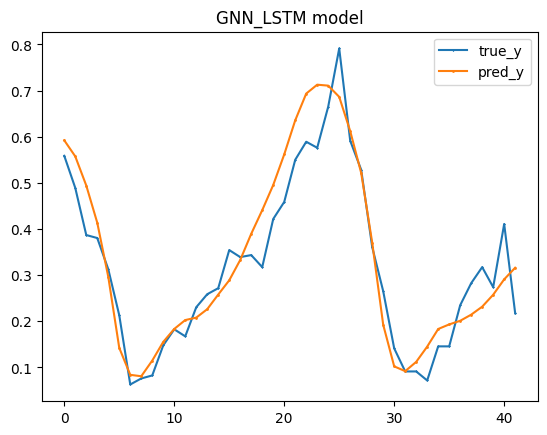

In [31]:
plt.title("GNN_LSTM model")
x=[i for i in range(len(y_valid))]
plt.plot(x,y_valid_passenger_count,marker="x",markersize=1,label="true_y")
plt.plot(x,preds_passenger_count,marker="o",markersize=1,label="pred_y")
plt.legend()
plt.show()

In [32]:
loss = 0
for i in range(len(y_valid)):
    loss += ((preds_passenger_count[i]-y_valid_passenger_count[i])**2)**0.5
    
print("总误差是{}".format(loss))

总误差是2.146461998962838
